In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Read dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data/selected_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
df_correct = df.loc[df['target'] == 1].iloc[:,:-1]
df_incorrect = df.loc[df['target'] == 0].iloc[:,:-1]

print('Target 1 shape: ' + str(df_correct.shape))
print('Target 0 shape: ' + str(df_incorrect.shape))

Target 1 shape: (5055, 38)
Target 0 shape: (4959, 38)


In [3]:
# Standarize the data
from sklearn.preprocessing import StandardScaler

cols = df_correct.columns.values
df_correct = pd.DataFrame(StandardScaler().fit_transform(df_correct), columns=cols)
df_incorrect = pd.DataFrame(StandardScaler().fit_transform(df_incorrect), columns=cols)

# PCA

In [4]:
from sklearn.decomposition import PCA
from models.model import ReconstructionErrorModel

# Fit reconstruction error model with correct data
model = ReconstructionErrorModel(df_correct, model=PCA(n_components=0.90))

# Calculate anomaly threshold with correct data
threshold = np.std(model.predict(df_correct)) * 3

In [5]:
model.get_model().explained_variance_

array([8.91526709, 6.41327153, 5.34798285, 3.98530838, 2.31712789,
       1.83134368, 1.54701764, 1.00408688, 0.82917674, 0.73210704,
       0.66840828, 0.55335279, 0.49974517])

In [6]:
# Calculate how many incorrect instances are detected as anomalies
errors = model.predict(df_incorrect)
anomalies = np.where(errors > threshold)[0]
print('Anomalies ' + str(len(anomalies)))

Anomalies 566


# SHAP

In [7]:
# Calculate anomalies shap values
import shap

anomaly_instances = df_incorrect.iloc[anomalies,:].reset_index(drop=True)
train_summary = shap.kmeans(anomaly_instances, 10)

explainer = shap.KernelExplainer(model.predict, train_summary)
shap_values = explainer.shap_values(anomaly_instances)

df_shap = pd.DataFrame(shap_values, columns=cols)

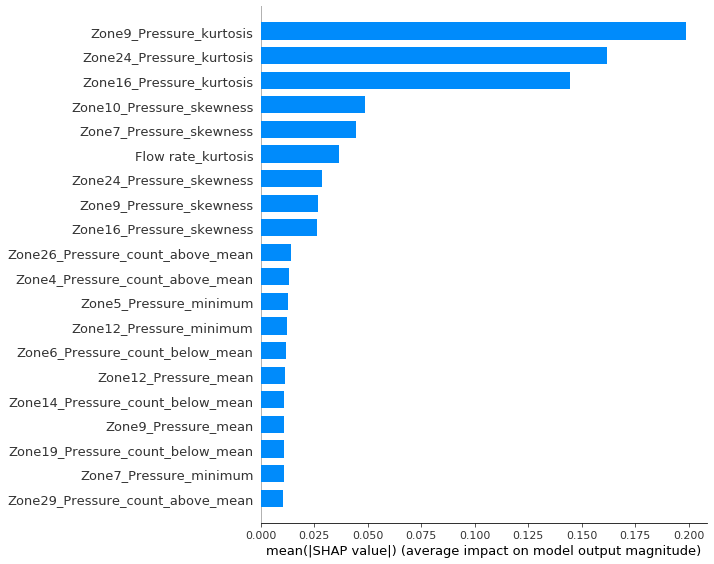

In [17]:
shap.summary_plot(df_shap, anomaly_instances, plot_type="bar")

# Clustering

In [21]:
from sklearn.cluster import DBSCAN

db_model = DBSCAN(eps=3, min_samples=2).fit(df_shap)
core_samples_mask = np.zeros_like(db_model.labels_, dtype=bool)
core_samples_mask[db_model.core_sample_indices_] = True
labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 3


In [22]:
import plotly.express as px

def scatter_2d(df, labels, X, Y):   
    df_plot = df.copy()
    df_plot['labels'] = labels
    fig = px.scatter(df_plot, x=X, y=Y, color='labels')
    fig.show()   


scatter_2d(df_shap, labels, 'Zone9_Pressure_kurtosis', 'Zone24_Pressure_kurtosis')